In [65]:
import torch 
import pandas as pd
import numpy as np

In [66]:
CODE_DIRECTORY = '/home/dsinghvi/code/shapley_residuals_llm/'
LANGUAGE = 'german'
PROB = 0.02
SUFFIX = '101'

In [67]:
# avg = pd.read_pickle(f'{CODE_DIRECTORY}/multilingual/avg_xlm-roberta-base100turkish.pkl')
mwe = pd.read_pickle(f'{CODE_DIRECTORY}/multilingual/mwe_xlm-roberta-base{SUFFIX}{LANGUAGE}{PROB}.pkl.gz')

In [68]:
import itertools
final = []

for tk in mwe:
    row_number = tk[0]
    m_split = tk[1]
    for k in m_split:
        combs = list(itertools.combinations(k, 2))
        for p in combs:
            final.append([row_number, p[0], p[1]])
mwe_df = pd.DataFrame(final, columns = ['row_number', 'first_token', 'second_token'])

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



def f_avg_df(path, method):
    import pickle
    abc = pd.read_pickle(path)
    
    # print(abc[0])
    abc = pd.DataFrame(abc, columns = ['tensor', 'posdis', 'row_number', 'first_token', 'second_token'])
    
    
    # abc = abc.iloc[:len(abc)//10].to_pickle(f'{path[:-8]}ok1.pkl.gz')
    abc = abc[abc['posdis']<=3].copy()
    print(len(abc))
    abc = abc.explode('tensor')
    abc['tensor'] = abc['tensor'].apply(lambda x : (x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7].cpu().detach(), x[8].cpu().detach(), x[9].cpu().detach(), x[10].cpu().detach()))
    abc[['method', 'tensor', 'token_next', 'AB', 'A', 'B', 'phi', 'lossAB', 'lossA', 'lossB', 'lossphi']] = abc['tensor'].to_list()
    abc = abc[abc['method'] == method].copy()
    print(len(abc))
    abc['predicted_token_dist_from_start'] = abc[['tensor', 'token_next']].apply(lambda x : list(range(x['token_next'], x['token_next'] + len(x['tensor']))), axis=1)
    abc = abc.explode(column=['tensor', 'predicted_token_dist_from_start', 'AB', 'A', 'B', 'phi', 'lossAB', 'lossA', 'lossB', 'lossphi'])
    abc = abc[abc['first_token']!= abc['predicted_token_dist_from_start']]
    abc = abc[abc['second_token']!= abc['predicted_token_dist_from_start']]
    abc = abc[abc['first_token'] != abc['second_token']].copy()
    abc['tensor'] = abc['tensor'].apply(lambda x : float(x))
    abc = abc.reset_index(drop=True)
    abc['max_token'] = abc[['first_token', 'second_token']].max(axis=1)
    abc['min_dist'] = abc['predicted_token_dist_from_start'] - abc['max_token']
    abc['rem'] = abc.groupby(['posdis','min_dist'])['row_number'].transform(lambda x : x.count())
    return abc
    

In [70]:
path = f'{CODE_DIRECTORY}/multilingual/avg_xlm-roberta-base{SUFFIX}{LANGUAGE}{PROB}.pkl.gz'
# path = f'{path[:-8]}ok1.pkl.gz'
avg_df = f_avg_df(path, 1)

43777


/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


43777


In [71]:
l = avg_df[(avg_df['min_dist'] == 1)]
l = l[l['lossAB']<=1]
strong_df = l.merge(mwe_df, on = ['row_number', 'first_token', 'second_token'])

strong_df.to_pickle(f'{SUFFIX}{LANGUAGE}{PROB}_strong_df.pkl')
l.to_pickle(f'{SUFFIX}{LANGUAGE}{PROB}_l.pkl')

In [119]:
version = '100_softmax'
load_avg = True
method = 1
def f_df(path, method):
    abc = pd.read_pickle(path, compression='gzip')
    abc = abc.explode('tensor')
    abc[['method', 'tensor', 'token_next']] = abc['tensor'].to_list()
    abc = abc[abc['method'] == method].copy()
    abc['predicted_token_dist_from_start'] = abc[['tensor', 'token_next']].apply(lambda x : list(range(x['token_next'], x['token_next'] + len(x['tensor']))), axis=1)
    abc = abc.explode(column=['tensor', 'predicted_token_dist_from_start'])
    
    abc['first_token'] = abc.apply(lambda x : x['ignore'][x['first_token']]-1, axis=1)
    abc['second_token'] = abc.apply(lambda x : x['ignore'][x['second_token']]-1, axis=1)
    
    abc = abc[abc['first_token']!= abc['predicted_token_dist_from_start']]
    abc = abc[abc['second_token']!= abc['predicted_token_dist_from_start']]
    
    
    abc = abc[abc['first_token'] != abc['second_token']].copy()
    abc['tensor'] = abc['tensor'].apply(lambda x : float(x))
    abc = abc.reset_index(drop=True)
    abc['max_token'] = abc[['first_token', 'second_token']].max(axis=1)
    abc['min_dist'] = abc['predicted_token_dist_from_start'] - abc['max_token']
    abc['rem'] = abc.groupby(['posdis','min_dist'])['row_number'].transform(lambda x : x.count())
    return abc

weak_path = f'../final/weak_mwe_gpt{version}.pkl'
weak_df = f_df(weak_path, method).drop(columns = ['ignore'])
weak_df = weak_df[weak_df['rem'] >= 50].copy()
display(weak_df)

,tensor,posdis,row_number,first_token,second_token,method,token_next,predicted_token_dist_from_start,max_token,min_dist,rem
0,1.035831,1,2,24,23,1,25,25,24,1,112781.0
1,1.015264,1,2,24,23,1,25,26,24,2,112574.0
2,0.990079,1,2,24,23,1,25,27,24,3,111813.0
3,0.836391,1,2,24,23,1,25,28,24,4,110268.0
4,0.345599,1,2,24,23,1,25,29,24,5,107987.0
...,...,...,...,...,...,...,...,...,...,...,...
2748760,0.689440,1,104014,4,3,1,5,5,4,1,112781.0
2748761,0.857080,1,104014,4,3,1,5,6,4,2,112574.0
2748762,0.454619,1,104014,4,3,1,5,7,4,3,111813.0
2748763,0.227409,1,104014,4,3,1,5,8,4,4,110268.0


In [ ]:
lang = 'english'
l = pd.read_pickle(f'{SUFFIX}{lang}{PROB}_l.pkl')
new_weak_df = l.merge(weak_df, on = ['row_number', 'first_token', 'second_token'])

In [124]:
weak_df

,tensor,posdis,row_number,first_token,second_token,method,token_next,predicted_token_dist_from_start,max_token,min_dist,rem
0,1.035831,1,2,24,23,1,25,25,24,1,112781.0
1,1.015264,1,2,24,23,1,25,26,24,2,112574.0
2,0.990079,1,2,24,23,1,25,27,24,3,111813.0
3,0.836391,1,2,24,23,1,25,28,24,4,110268.0
4,0.345599,1,2,24,23,1,25,29,24,5,107987.0
...,...,...,...,...,...,...,...,...,...,...,...
2748760,0.689440,1,104014,4,3,1,5,5,4,1,112781.0
2748761,0.857080,1,104014,4,3,1,5,6,4,2,112574.0
2748762,0.454619,1,104014,4,3,1,5,7,4,3,111813.0
2748763,0.227409,1,104014,4,3,1,5,8,4,4,110268.0


In [127]:
l#.merge(weak_df, on = ['row_number', 'first_token', 'second_token'])

,tensor,posdis,row_number,first_token,second_token,method,token_next,AB,A,B,phi,lossAB,lossA,lossB,lossphi,predicted_token_dist_from_start,max_token,min_dist,rem
4,0.000612,1,3,4,5,1,0,tensor(1.0000),tensor(1.0000),tensor(1.0000),tensor(0.9995),tensor(1.7881e-06),tensor(8.9407e-06),tensor(8.9407e-06),tensor(0.0005),6,5,1,10292
53,0.794604,2,3,4,6,1,0,tensor(1.0000),tensor(1.0000),tensor(1.0000),tensor(0.3071),tensor(1.7881e-06),tensor(1.4305e-06),tensor(1.4305e-06),tensor(1.4634),7,6,1,9870
102,0.000399,3,3,4,7,1,0,tensor(0.9999),tensor(0.9999),tensor(0.9999),tensor(0.9995),tensor(6.8185e-05),tensor(0.0001),tensor(0.0001),tensor(0.0005),8,7,1,9758
153,0.001104,1,5,9,10,1,0,tensor(1.0000),tensor(1.0000),tensor(1.0000),tensor(0.9991),tensor(9.5367e-06),tensor(7.9870e-06),tensor(7.9870e-06),tensor(0.0009),11,10,1,10292
202,0.000003,2,5,9,11,1,0,tensor(1.0000),tensor(1.0000),tensor(1.0000),tensor(1.0000),tensor(8.3446e-07),tensor(3.5763e-07),tensor(3.5763e-07),tensor(2.1458e-06),12,11,1,9870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313332,0.305100,3,43985,20,23,1,0,tensor(0.9999),tensor(0.9973),tensor(0.9973),tensor(0.7177),tensor(0.0001),tensor(0.0027),tensor(0.0027),tensor(0.3434),24,23,1,9758
1313382,0.020461,1,43986,24,25,1,0,tensor(1.0000),tensor(0.9997),tensor(0.9997),tensor(0.9798),tensor(1.5259e-05),tensor(0.0003),tensor(0.0003),tensor(0.0205),26,25,1,10292
1313429,0.010202,1,43992,23,24,1,0,tensor(0.9957),tensor(0.9900),tensor(0.9900),tensor(0.9747),tensor(0.0043),tensor(0.0101),tensor(0.0101),tensor(0.0257),25,24,1,10292
1313478,0.000790,2,43992,23,25,1,0,tensor(1.),tensor(1.0000),tensor(1.0000),tensor(0.9992),tensor(-0.),tensor(3.6955e-06),tensor(3.6955e-06),tensor(0.0008),26,25,1,9870


43539 7398
16130 3180
29660 3318


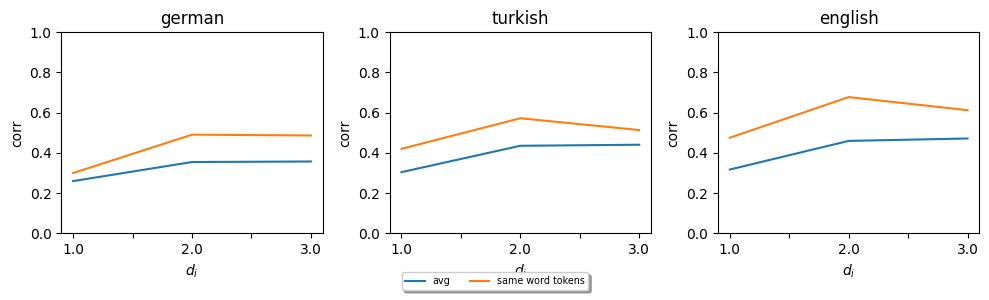

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
for i, lang in enumerate(['german', 'turkish', 'english']):
    strong_df = pd.read_pickle(f'{SUFFIX}{lang}{PROB}_strong_df.pkl')
    l = pd.read_pickle(f'{SUFFIX}{lang}{PROB}_l.pkl')
    print(len(l), len(strong_df))

    m = strong_df[(strong_df['min_dist'] == 1)]
    # p = l.groupby('posdis').apply(lambda x : x.corr('spearman')['lossAB']['tensor']).reset_index().rename(columns = {0 : 'corr', 'posdis': f'$t_2 - t_1$'})
    # q = m.groupby('posdis').apply(lambda x : x.corr('spearman')['lossAB']['tensor']).reset_index().rename(columns = {0 : 'corr', 'posdis': f'$t_2 - t_1$'})

    # sns.lineplot(data=p, x=f'$t_2 - t_1$', y='corr',  label='avg', ax = axes[i])
    # sns.lineplot(data=q, x=f'$t_2 - t_1$', y='corr',  label='same word\ntokens', ax = axes[i])

    p = l.groupby('posdis').apply(lambda x : x.corr('spearman')['lossAB']['tensor']).reset_index().rename(columns = {0 : 'corr', 'posdis': f'$d_i$'})
    q = m.groupby('posdis').apply(lambda x : x.corr('spearman')['lossAB']['tensor']).reset_index().rename(columns = {0 : 'corr', 'posdis': f'$d_i$'})

    sns.lineplot(data=p, x=f'$d_i$', y='corr',  label='avg', ax = axes[i])
    sns.lineplot(data=q, x=f'$d_i$', y='corr',  label='same word tokens', ax = axes[i])
    
    for ind, label in enumerate(axes[i].get_xticklabels()):
        if label.get_position()[0].is_integer():  # every 10th label is kept
            label.set_text(int(label.get_text()[0]))
            label.set_visible(True)
        else:
            label.set_visible(False)
    # strong_line = sns.lineplot(data=strong_df[strong_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='strong')
    # weak_line = sns.lineplot(data=weak_df[weak_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='weak')
    # avg_line = sns.lineplot(data=avg_df[avg_df['min_dist'] == min_dist], x="posdis", y="tensor", ax=axes[j][i], label='avg')
    axes[i].set_title(f'{lang}')

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].get_legend().remove()
    axes[i].set_ylim(0, 1)
    # axes[i].legend()
# fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.49, 0.4, 0.498, 0.49))
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=2)
plt.rc('legend',fontsize='x-small')
fig.tight_layout()
plt.savefig('correlation_language_comparison_plot.png', bbox_inches='tight')

plt.show()

43539 7398
16130 3180
29660 3318


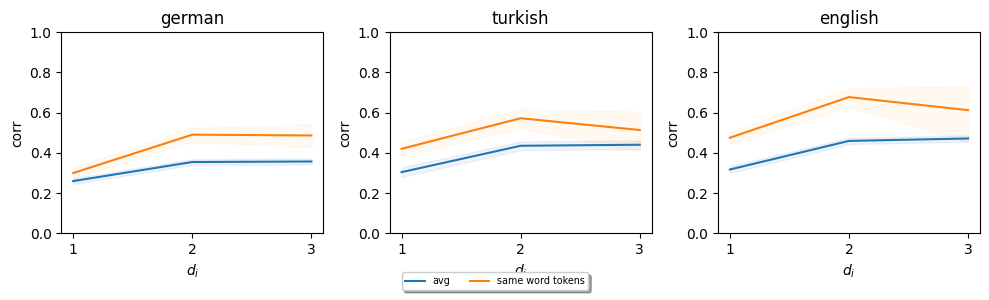

In [110]:
from scipt.stats import stats
def calculate_corr_ci(data):
    rho = data.groupby('posdis')[['lossAB','tensor']].corr(method = lambda x, y : stats.spearmanr(x, y)[0])['lossAB'].unstack()['tensor']
    cnt = data.groupby('posdis')['lossAB'].count()
    
    # Calculate confidence interval for Spearman correlation
    alpha = 0.05
    z = stats.norm.ppf(1 - alpha / 2)
    se_rho = 1 / np.sqrt(cnt - 3)
    
    ci_lower = np.tanh(np.arctanh(rho) - z * se_rho)
    ci_upper = np.tanh(np.arctanh(rho) + z * se_rho)
    
    return rho, ci_lower, ci_upper


fig, axes = plt.subplots(1, 3, figsize=(10,3))
for i, lang in enumerate(['german', 'turkish', 'english']):
    strong_df = pd.read_pickle(f'{SUFFIX}{lang}{PROB}_strong_df.pkl')
    l = pd.read_pickle(f'{SUFFIX}{lang}{PROB}_l.pkl')
    print(len(l), len(strong_df))

    m = strong_df[(strong_df['min_dist'] == 1)]
    # p = l.groupby('posdis').apply(lambda x : x.corr('spearman')['lossAB']['tensor']).reset_index().rename(columns = {0 : 'corr', 'posdis': f'$t_2 - t_1$'})
    # q = m.groupby('posdis').apply(lambda x : x.corr('spearman')['lossAB']['tensor']).reset_index().rename(columns = {0 : 'corr', 'posdis': f'$t_2 - t_1$'})

    # sns.lineplot(data=p, x=f'$t_2 - t_1$', y='corr',  label='avg', ax = axes[i])
    # sns.lineplot(data=q, x=f'$t_2 - t_1$', y='corr',  label='same word\ntokens', ax = axes[i])

    p = l.groupby('posdis').apply(lambda x : x.corr('spearman')['lossAB']['tensor']).reset_index().rename(columns = {0 : 'corr', 'posdis': f'$d_i$'})
    q = m.groupby('posdis').apply(lambda x : x.corr('spearman')['lossAB']['tensor']).reset_index().rename(columns = {0 : 'corr', 'posdis': f'$d_i$'})

    rho, p_ci_lower, p_ci_upper = calculate_corr_ci(l)
    rho, q_ci_lower, q_ci_upper = calculate_corr_ci(m)
    dark_orange = '#FF8C00'  # You can use hexadecimal or named colors
    dark_blue = '#00008B'
    
    p['$d_i$'] = p['$d_i$'].astype(str)

    sns.lineplot(data=p, x=f'$d_i$', y='corr',  label='avg', ax = axes[i], ci=None)

    axes[i].fill_between(x=p['$d_i$'], y1=p_ci_lower, y2=p_ci_upper, color=dark_blue, alpha=0.05)

    q['$d_i$'] = q['$d_i$'].astype(str)
    
    sns.lineplot(data=q, x=f'$d_i$', y='corr',  label='same word tokens', ax = axes[i],ci=None)
    # axes[i].fill_between(x=p['$d_i$'], y1=p_ci_lower, y2=p_ci_upper, color='gray', alpha=0.2, label=f'CI: {p_ci_lower:.2f} to {p_ci_upper:.2f}')
    axes[i].fill_between(x=q['$d_i$'], y1=q_ci_lower, y2=q_ci_upper, color=dark_orange, alpha=0.05)


    
    # for ind, label in enumerate(axes[i].get_xticklabels()):
    #     if label.get_position()[0].is_integer():  # every 10th label is kept
    #         label.set_text(int(label.get_text()[0]))
    #         label.set_visible(True)
    #     else:
    #         label.set_visible(False)
    # strong_line = sns.lineplot(data=strong_df[strong_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='strong')
    # weak_line = sns.lineplot(data=weak_df[weak_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='weak')
    # avg_line = sns.lineplot(data=avg_df[avg_df['min_dist'] == min_dist], x="posdis", y="tensor", ax=axes[j][i], label='avg')
    axes[i].set_title(f'{lang}')

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].get_legend().remove()
    axes[i].set_ylim(0, 1)
    # axes[i].legend()
# fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.49, 0.4, 0.498, 0.49))
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=2)
plt.rc('legend',fontsize='x-small')
fig.tight_layout()
plt.savefig('correlation_language_comparison_plot.png', bbox_inches='tight')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
for i, lang in enumerate(['german', 'turkish', 'english']):
    strong_df = pd.read_pickle(f'{SUFFIX}{lang}{PROB}_strong_df.pkl')
    l = pd.read_pickle(f'{SUFFIX}{lang}{PROB}_l.pkl')
    print(len(l), len(strong_df))

    m = strong_df[(strong_df['min_dist'] == 1)]
    l = l.rename(columns = {'posdis': 'd'})#f'$t_2 - t_1$'})
    m = m.rename(columns = {'posdis': 'd'})#f'$t_2 - t_1$'})
# f'$t_2 - t_1$'
    if l['lossAB'].dtype != 'float64':
        l['lossAB'] = l['lossAB'].apply(lambda x : x.numpy())
        m['lossAB'] = m['lossAB'].apply(lambda x : x.numpy())
    
    sns.lineplot(data=l, x='d', y='lossAB',  label='avg', ax = axes[i])
    sns.lineplot(data=m, x='d', y='lossAB',  label='same word\ntokens', ax = axes[i])

    for ind, label in enumerate(axes[i].get_xticklabels()):
        if label.get_position()[0].is_integer():  # every 10th label is kept
            label.set_text(int(label.get_text()[0]))
            label.set_visible(True)
        else:
            label.set_visible(False)
    axes[i].set_title(f'{lang}')

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].get_legend().remove()
    # axes[i].set_ylim(0, 1)
    # axes[i].legend()
fig.legend(handles, labels, loc='upper right')
plt.rc('legend',fontsize='x-small')
fig.tight_layout()
plt.savefig('loss_comparison_plot.png', bbox_inches='tight')
plt.show()

In [168]:
l['lossAB'].dtype == 'float64'

True

In [ ]:
avg_df['lossAB'] = avg_df['lossAB'].apply(lambda x : x.numpy())

In [10]:
avg_df['AB'] = avg_df['AB'].apply(lambda x : x.numpy())

In [11]:
avg_df['lossAB_quantile'] = ((avg_df['lossAB'].rank(pct=True)*100)//10).astype(int)
avg_df['lossAB_quantile']

0          0
1          5
2          5
3          9
4          0
          ..
1459842    0
1459843    2
1459844    5
1459845    6
1459846    9
Name: lossAB_quantile, Length: 1459847, dtype: int64

In [12]:
avg_df['AB_quantile'] = ((avg_df['AB'].rank(pct=True)*100)//10).astype(int)
avg_df['AB_quantile']

0          9
1          4
2          4
3          0
4          9
          ..
1459842    9
1459843    7
1459844    4
1459845    3
1459846    0
Name: AB_quantile, Length: 1459847, dtype: int64

Comparison
1. avg_loss for same word token vs same multi word token(english) 
- Correlation numbers
<!-- - bar plot with correlation scores (correlation for same word, each language, ) (all language) -->
- bar plot avg loss (english same word vs mwe english)
- loss on each language / loss on each word / mwe english

43539 7398


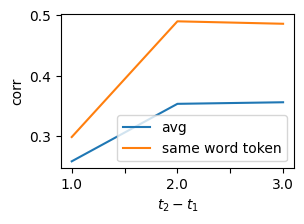

In [ ]:
for posdis in range(1, 5):
    l = avg_df[(avg_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]
    l = l[l['lossAB']<=1]
    strong_df = l.merge(mwe_df, on = ['row_number', 'first_token', 'second_token'])
    m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]
    display("Avg",l.corr('spearman')['lossAB']['tensor'])
    display("Strong",m.corr('spearman')['lossAB']['tensor'])
    
    sns.scatterplot(data=l, x="lossAB", y="tensor",  label='avg')
    sns.scatterplot(data=m, x="lossAB", y="tensor",  label='strong')
    plt.show()

/tmp/ipykernel_3550/3308107155.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]


0.1923001445524261

0.2731020909783301

/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)


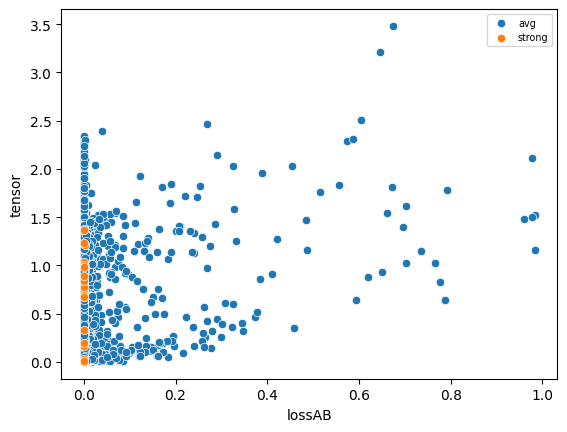

/tmp/ipykernel_3550/3308107155.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]


0.24452316574489658

0.9748565570007439

/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)


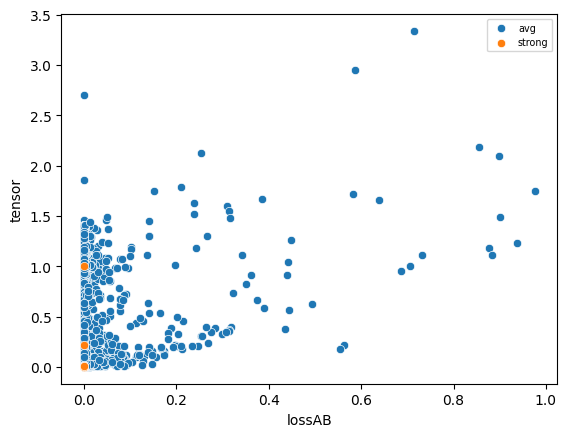

/tmp/ipykernel_3550/3308107155.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]


0.25479540542224216

nan

/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)


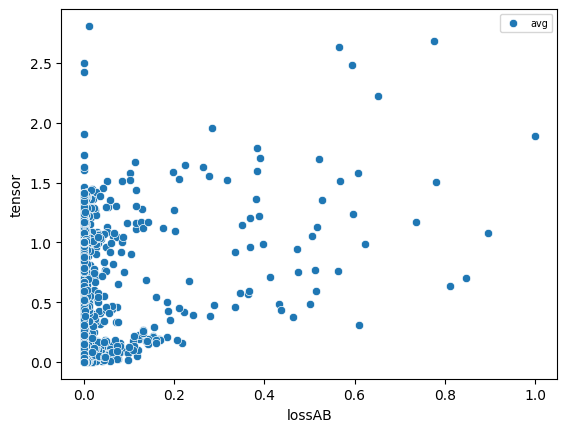

/tmp/ipykernel_3550/3308107155.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]


nan

nan

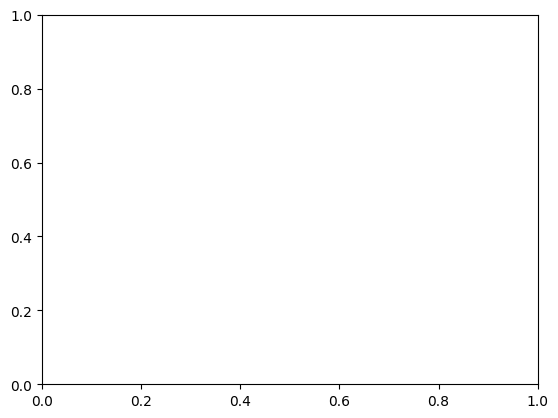

In [49]:
for posdis in range(1, 5):
    l = avg_df[(avg_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]
    l = l[l['lossAB']<=1]
    strong_df = l.merge(mwe_df, on = ['row_number', 'first_token', 'second_token'])
    m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]
    display(l.corr()['lossAB']['tensor'])
    display(m.corr()['lossAB']['tensor'])
    
    sns.scatterplot(data=l, x="lossAB", y="tensor",  label='avg')
    sns.scatterplot(data=m, x="lossAB", y="tensor",  label='strong')
    plt.show()

/tmp/ipykernel_3550/1999357944.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)


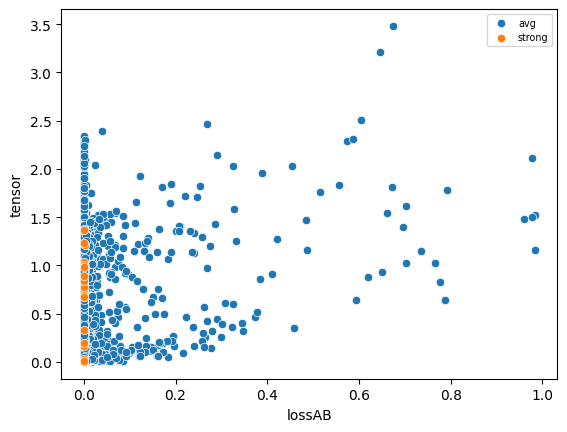

/tmp/ipykernel_3550/1999357944.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)


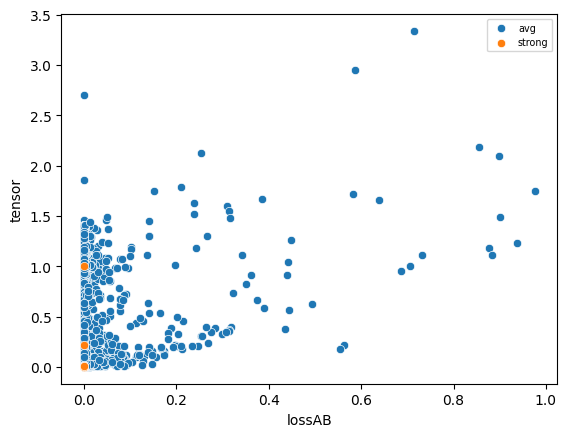

/tmp/ipykernel_3550/1999357944.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/dsinghvi/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)


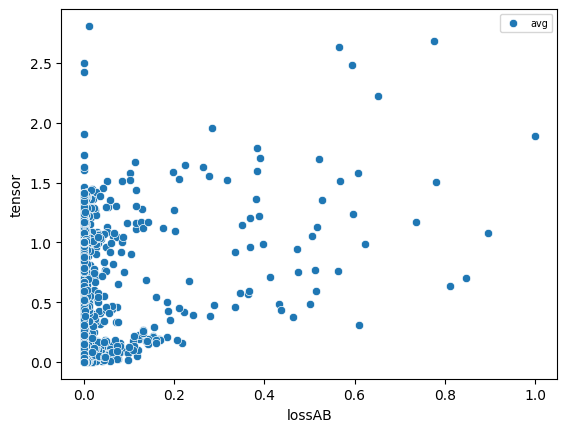

/tmp/ipykernel_3550/1999357944.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]


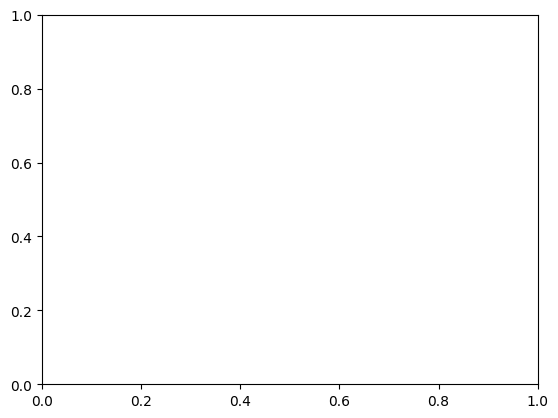

In [50]:
for posdis in range(1, 5):
    l = avg_df[(avg_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]
    strong_df = l.merge(mwe_df, on = ['row_number', 'first_token', 'second_token'])
    m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]
    sns.scatterplot(data=l, x="lossAB", y="tensor",  label='avg')
    sns.scatterplot(data=m, x="lossAB", y="tensor",  label='strong')
    plt.show()

posdis 1


/tmp/ipykernel_513/2609728188.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]


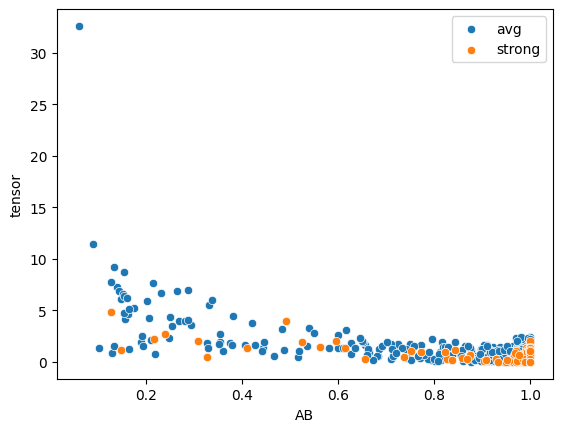

posdis 2


/tmp/ipykernel_513/2609728188.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]


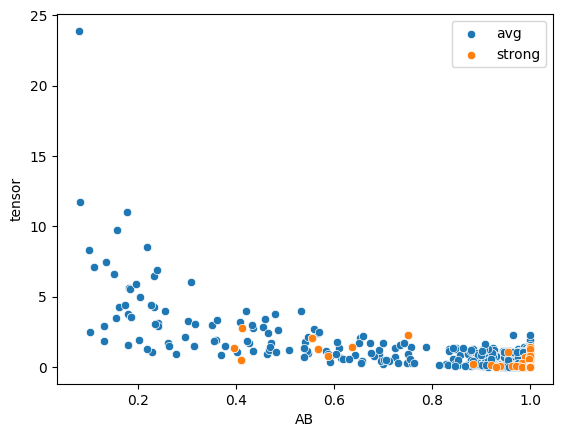

posdis 3


/tmp/ipykernel_513/2609728188.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]


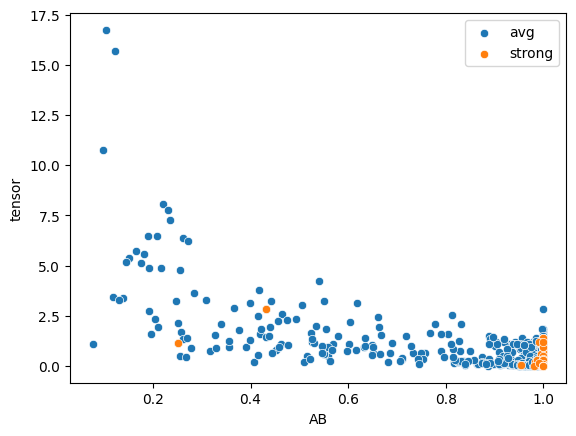

In [16]:
for posdis in range(1, 4):
    print(f'posdis {posdis}')
    l = avg_df[(avg_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]
    strong_df = l.merge(mwe_df, on = ['row_number', 'first_token', 'second_token'])
    m = strong_df[(strong_df['min_dist'] == 1) & (avg_df['posdis']==posdis)]
    sns.scatterplot(data=l, x="AB", y="tensor",  label='avg')
    sns.scatterplot(data=m, x="AB", y="tensor",  label='strong')
    plt.show()

In [13]:
def plot(strong_df, weak_df, avg_df):
    # fig, axes = plt.subplots(2, 4, figsize=(30,10))
    fig, axes = plt.subplots(2, 2, figsize=(10,5))
    
    
    for i in range(0, 1):
        for j in [0]:
            min_dist = j*4 + i + 1
            
            strong_line = sns.lineplot(data=strong_df[strong_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='strong')
            weak_line = sns.lineplot(data=weak_df[weak_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='weak')
            avg_line = sns.lineplot(data=avg_df[avg_df['min_dist'] == min_dist], x="posdis", y="tensor", ax=axes[j][i], label='avg')
            # axes[j][i].set_title(f'$t_{{target}} - t_2$ = {min_dist}')
            axes[j][i].set_title(f'$d_p$ = {min_dist}')
            axes[j][i].set_xlabel(f'$d_i$')
            axes[j][i].legend()
    plt.show()


for quantile, grp in avg_df.groupby('lossAB_quantile'):
    print(quantile)
    strong_df = grp.merge(mwe_df, on = ['row_number', 'first_token', 'second_token'])
    # weak_df = avg_df.merge(mwe_df, on = ['row_number', 'first_token', 'second_token'], how = 'outer', indicator=True)f
    # weak_df = weak_df[weak_df['_merge'] == 'left_only']
    plot(strong_df[strong_df['posdis']<=4], strong_df[strong_df['posdis']<=4], grp[grp['posdis']<=4])

KeyError: 'lossAB_quantile'

In [ ]:
for quantile, grp in avg_df.groupby('AB_quantile'):
    print(quantile)
    strong_df = grp.merge(mwe_df, on = ['row_number', 'first_token', 'second_token'])
    # weak_df = avg_df.merge(mwe_df, on = ['row_number', 'first_token', 'second_token'], how = 'outer', indicator=True)f
    # weak_df = weak_df[weak_df['_merge'] == 'left_only']
    plot(strong_df[strong_df['posdis']<=4], strong_df[strong_df['posdis']<=4], grp[grp['posdis']<=4])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


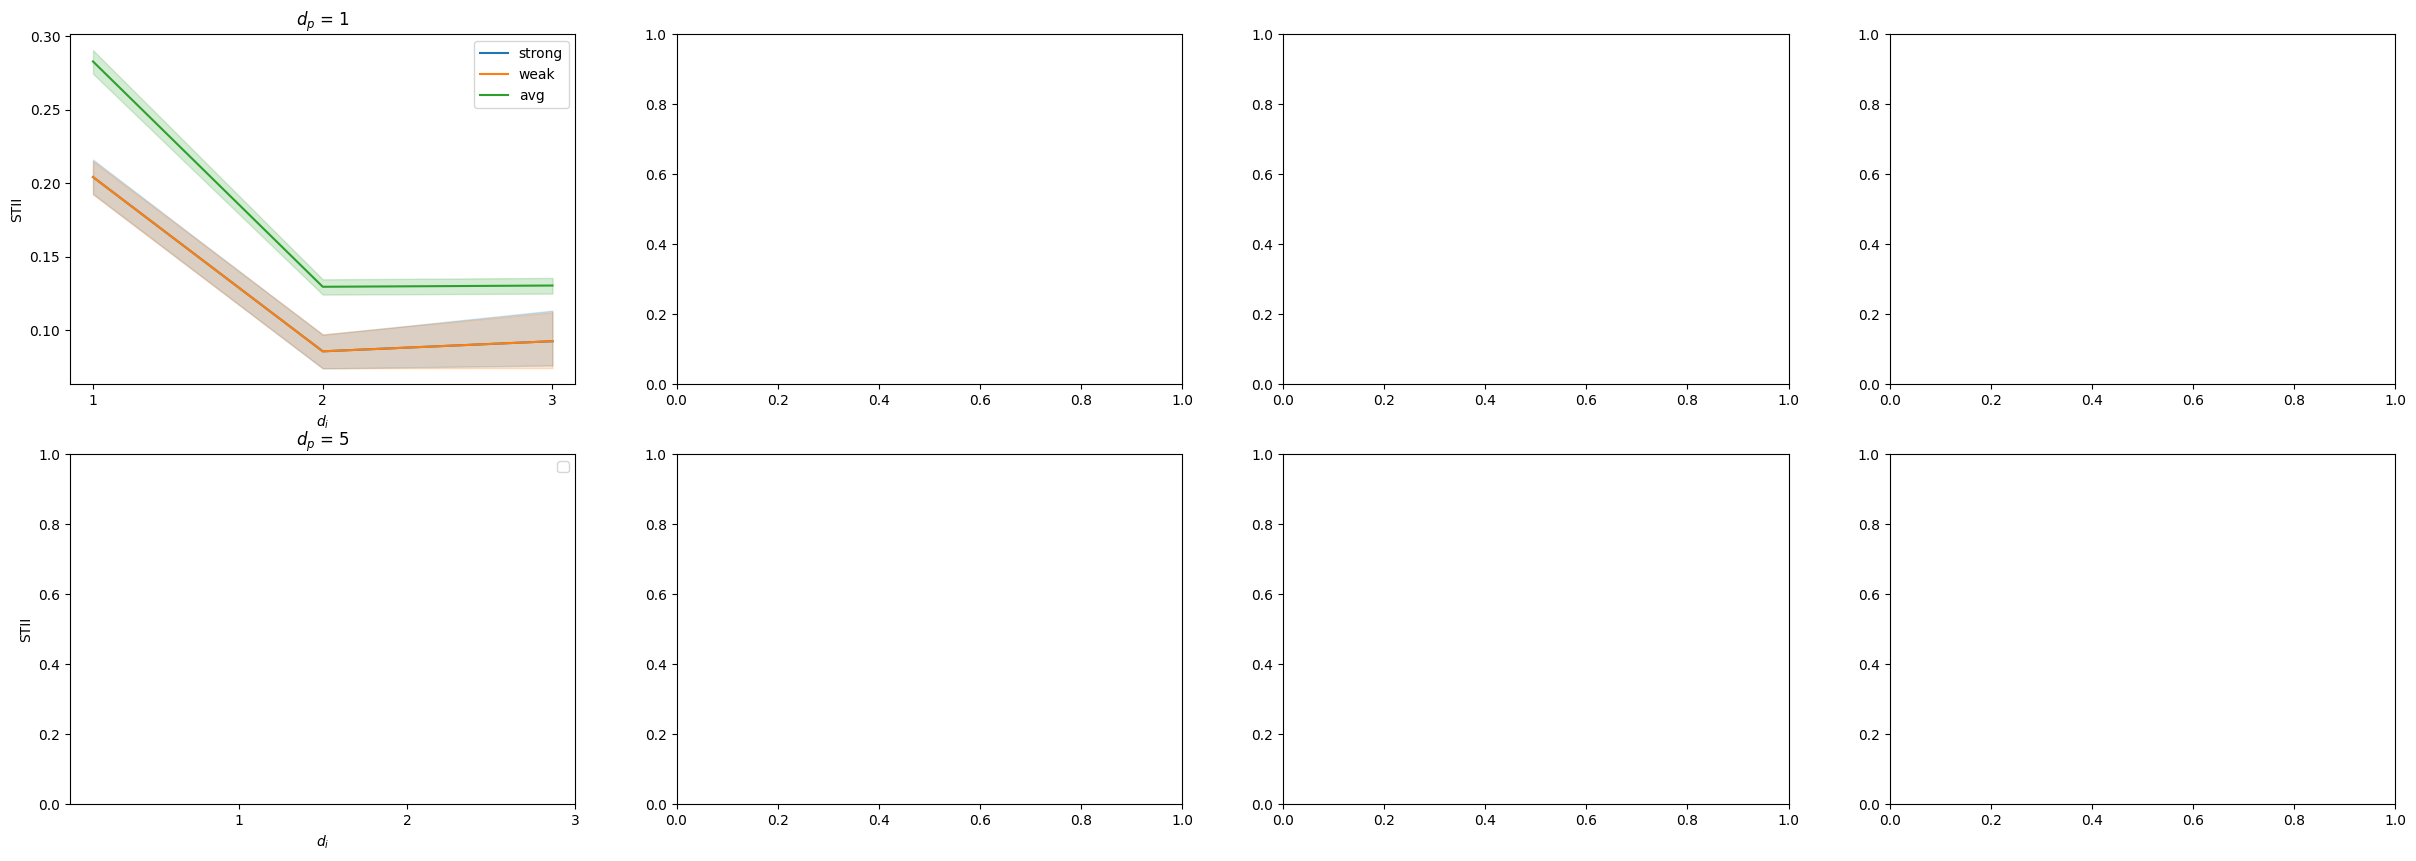

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


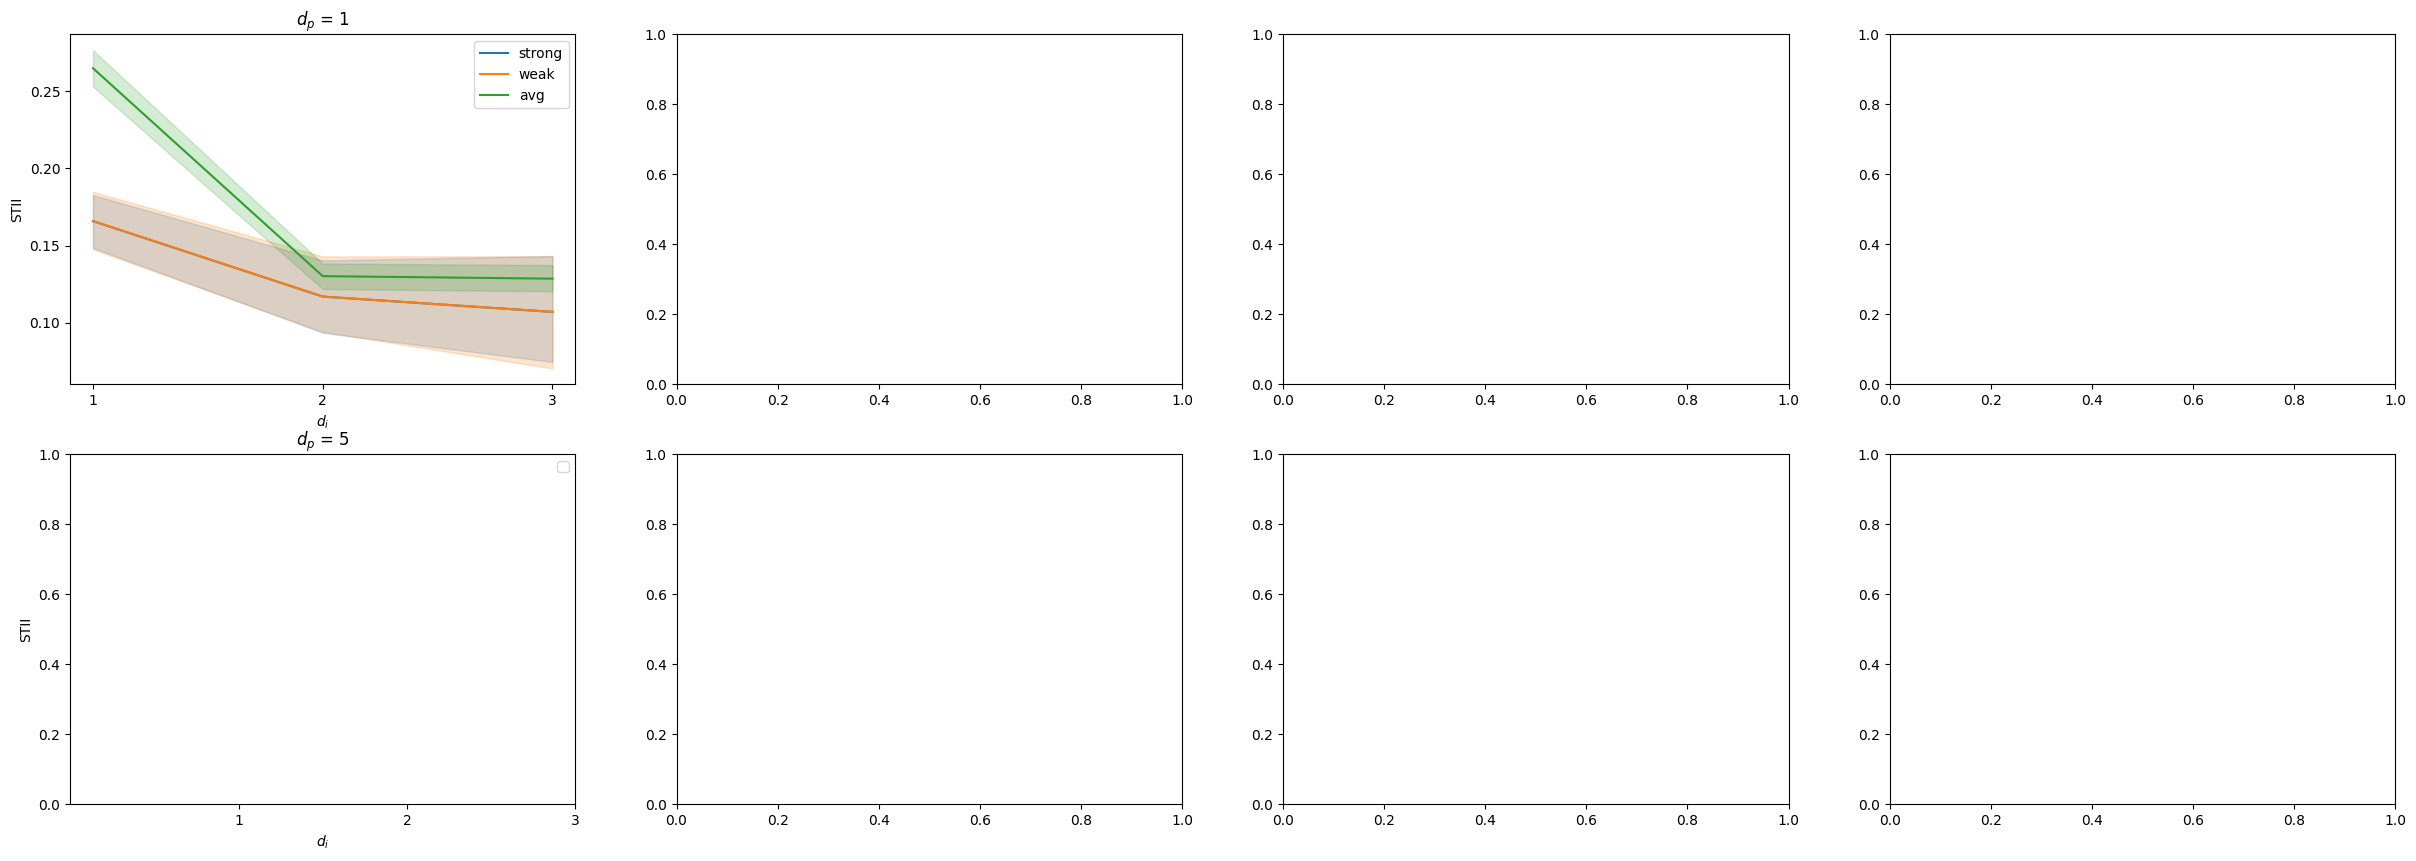

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


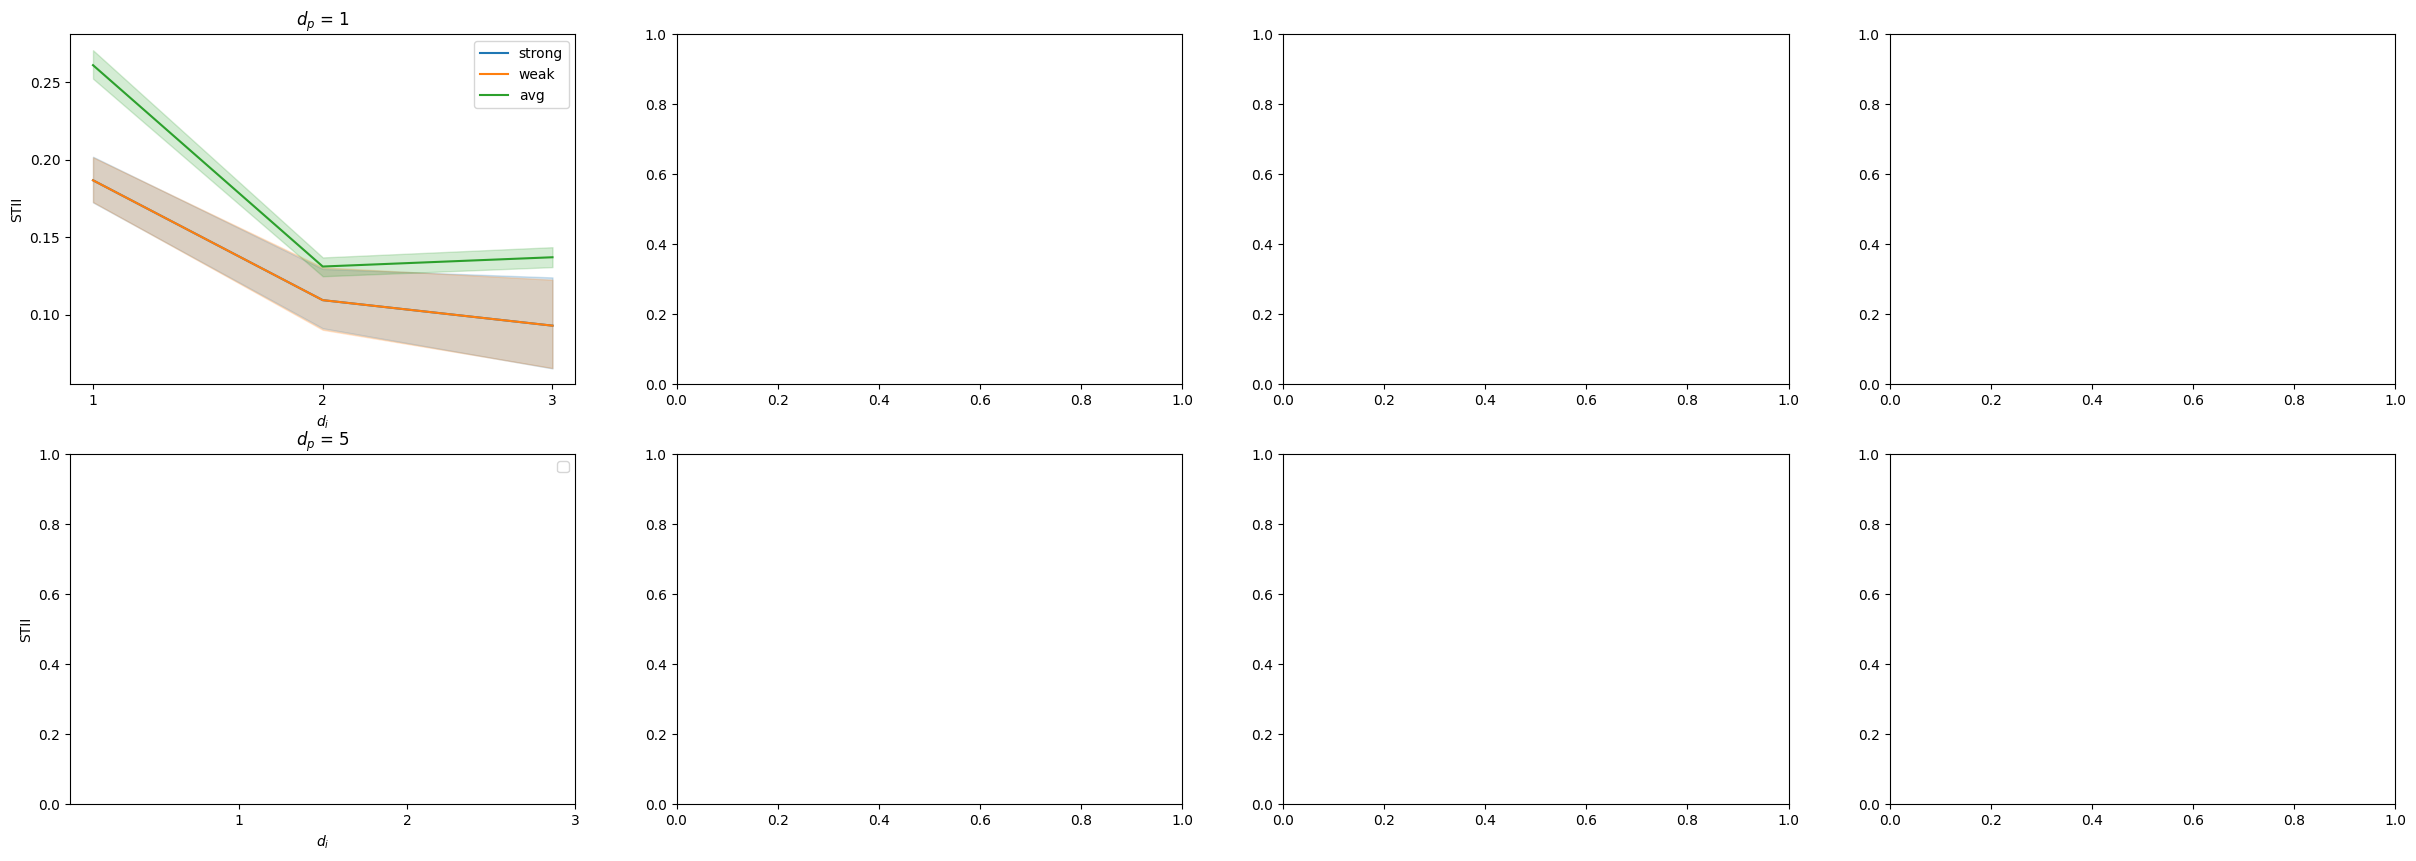

In [14]:
def plot(strong_df, weak_df, avg_df):
    fig, axes = plt.subplots(2, 4, figsize=(30,10))
    
    for i in range(0, 1):
        for j in [0,1]:
            min_dist = j*4 + i + 1
            
            strong_line = sns.lineplot(data=strong_df[strong_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='strong')
            weak_line = sns.lineplot(data=weak_df[weak_df['min_dist'] ==min_dist], x="posdis", y="tensor", ax=axes[j][i], label='weak')
            avg_line = sns.lineplot(data=avg_df[avg_df['min_dist'] == min_dist], x="posdis", y="tensor", ax=axes[j][i], label='avg')
            # axes[j][i].set_title(f'$t_{{target}} - t_2$ = {min_dist}')
            axes[j][i].set_title(f'$d_p$ = {min_dist}')
            axes[j][i].set_xlabel(f'$d_i$')
            axes[j][i].set_xticks([1, 2, 3])
            axes[j][i].set_ylabel('STII')
            axes[j][i].legend()
    plt.show()

for i, lang in enumerate(['german', 'turkish', 'english']):
    # strong_df = pd.read_pickle(f'{SUFFIX}{lang}{PROB}_strong_df.pkl')
    avg_df = pd.read_pickle(f'{SUFFIX}{lang}{PROB}_l.pkl')
    
    avg_df['posdis'] = avg_df['posdis'].astype(int)
    mwe_df['first_token'] = mwe_df['first_token'] + 1
    mwe_df['second_token'] = mwe_df['second_token'] + 1
    strong_df = avg_df.merge(mwe_df, on = ['row_number', 'first_token', 'second_token'])
    # weak_df = avg_df.merge(mwe_df, on = ['row_number', 'first_token', 'second_token'], how = 'outer', indicator=True)
    # weak_df = weak_df[weak_df['_merge'] == 'left_only']
    plot(strong_df[strong_df['posdis']<=4], strong_df[strong_df['posdis']<=4], avg_df[avg_df['posdis']<=4])

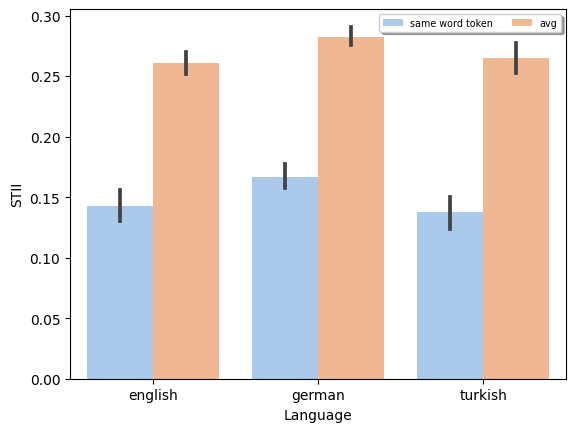

In [219]:
# fig, axes = plt.subplots(1, 3, figsize=(10,2.5), sharey=True, sharex=True)

s_df = []
a_df = []
for i, lang in enumerate(['english', 'german', 'turkish']):
    strong_df = pd.read_pickle(f'{SUFFIX}{lang}{PROB}_strong_df.pkl')
    avg_df = pd.read_pickle(f'{SUFFIX}{lang}{PROB}_l.pkl')

    strong_df = strong_df[strong_df['min_dist'] ==1]
    avg_df = avg_df[avg_df['min_dist'] ==1]

    strong_df = strong_df[strong_df['posdis'] ==1]
    avg_df = avg_df[avg_df['posdis'] ==1]

    strong_df['lang'] = lang
    avg_df['lang'] = lang

    s_df.append(strong_df)
    a_df.append(avg_df)

s_df = pd.concat(s_df)
a_df = pd.concat(a_df)
s_df['type'] = 'same word token'
a_df['type'] = 'avg'

s_df = pd.concat([s_df, a_df], ignore_index=True)
strong_line = sns.barplot(data=s_df, x="lang", y="tensor", hue='type', palette='pastel')
# avg_line = sns.barplot(data=a_df, x="lang", y="tensor",  label='avg')

# axes[i].set_title(f'{lang}')
# axes[i].set_xlabel(f'$d_i$')
plt.xlabel('Language')
plt.ylabel('STII')
# axes[i].set_xticks([1, 2, 3])
# axes[i].set_ylabel('STII')
# handles, labels = axes[i].get_legend_handles_labels()
# axes[i].get_legend().remove()
strong_line.legend(loc='upper right', fancybox=True, shadow=True, ncol=2)
fig.tight_layout()
plt.savefig('multilingual_interaction1.png', bbox_inches='tight')
plt.show()

0.3338624135036222 0.29893195111228205 0.316504471042272
0.5033526487018909 0.4450196579961297 0.47470728628272435
0.273860899611613 0.24403881678834283 0.25901158681860437
0.32449563843890455 0.27325916463122923 0.29909296406460095
0.32718539861575374 0.27942226087665234 0.30349447019522274
0.45325520919880047 0.38467704151887155 0.41956463239576774


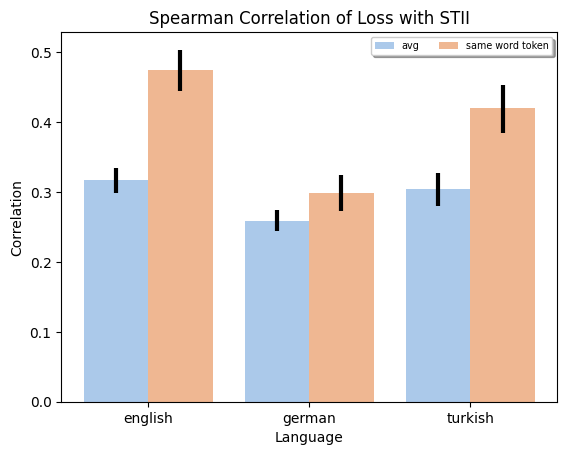

In [236]:
from scipy import stats
def calculate_corr_ci(data):
    rho = data.groupby(['lang', 'type'])[['lossAB','tensor']].corr(method = lambda x, y : stats.spearmanr(x, y)[0])['lossAB'].unstack()['tensor']
    cnt = data.groupby(['lang', 'type'])['lossAB'].count()
    
    # Calculate confidence interval for Spearman correlation
    alpha = 0.05
    z = stats.norm.ppf(1 - alpha / 2)
    se_rho = 1 / np.sqrt(cnt - 3)
    
    ci_lower = np.tanh(np.arctanh(rho) - z * se_rho)
    ci_upper = np.tanh(np.arctanh(rho) + z * se_rho)
    
    return rho, ci_lower, ci_upper

s_df = []
a_df = []
for i, lang in enumerate(['german', 'turkish', 'english']):
    strong_df = pd.read_pickle(f'{SUFFIX}{lang}{PROB}_strong_df.pkl')
    avg_df = pd.read_pickle(f'{SUFFIX}{lang}{PROB}_l.pkl')

    strong_df = strong_df[strong_df['min_dist'] ==1]
    avg_df = avg_df[avg_df['min_dist'] ==1]

    strong_df = strong_df[strong_df['posdis'] ==1]
    avg_df = avg_df[avg_df['posdis'] ==1]

    strong_df['lang'] = lang
    avg_df['lang'] = lang

    s_df.append(strong_df)
    a_df.append(avg_df)
    
s_df = pd.concat(s_df)
a_df = pd.concat(a_df)
s_df['type'] = 'same word token'
a_df['type'] = 'avg'
# s_df = a_df
s_df = pd.concat([s_df, a_df], ignore_index=True)

p = s_df.groupby(['lang', 'type'])[['lossAB','tensor']].apply(lambda x :  x.corr('spearman')['lossAB']['tensor']).reset_index().rename(columns = {0 : 'corr', 'posdis': f'$d_i$'})

# strong_line = sns.barplot(data=p, x="lang", y="corr", hue='type', palette='pastel', linestyle='solid')


rho, p_ci_lower, p_ci_upper = calculate_corr_ci(s_df)

# Prepare separate arrays for error bars for each hue category (type)
# p_ci_lower = p_ci_lower.unstack().values.flatten()
# p_ci_upper = p_ci_upper.unstack().values.flatten()

# p_ci_lower = p_ci_lower.reset_index().rename(columns = {0: 'corr'})
# p_ci_upper = p_ci_upper.reset_index().rename(columns = {0: 'corr'})

    
# strong_line = sns.barplot(data=p, x="lang", y="corr", hue='type', palette='pastel', errcolor='black', yerr=[p_ci_lower, p_ci_upper])
# plt.show()
strong_line = sns.barplot(data=p, x="lang", y="corr", hue='type', palette='pastel')


def get_x(i):
    if i == 0:
        return -0.2
    if i == 1:
        return 0.2
    elif i == 2:
        return 0.8
    elif i == 3:
        return 1.2
    elif i == 4:
        return 1.8
    else:
        return 2.2

# Add error bars
for i, (lower, upper) in enumerate(zip(p_ci_lower.values.flatten(), p_ci_upper.values.flatten())):
    print(upper, lower, p['corr'].iloc[i])
    strong_line.errorbar(
        x=get_x(i),#['english', 'german', 'turkish'][i],
        y=p['corr'].iloc[i],
        yerr=[[ p['corr'].iloc[i] - lower], [upper - p['corr'].iloc[i]]],
        fmt='none',
        color='black',
        capthick = 100, 
        elinewidth=3
        # capsize=5
    )

strong_line.legend(loc='upper right', fancybox=True, shadow=True, ncol=2)
plt.title('Spearman Correlation of Loss with STII')
plt.xlabel('Language')
plt.ylabel('Correlation')
# plt.legend(title='Type')
plt.savefig('correlation_language_comparison_plot1.png', bbox_inches='tight')

plt.show()


# handles, labels = axes[i].get_legend_handles_labels()
# axes[i].get_legend().remove()
# axes[i].set_ylim(0, 1)
#     # axes[i].legend()
# # fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.49, 0.4, 0.498, 0.49))
# plt.rc('legend',fontsize='x-small')
# fig.tight_layout()
# plt.savefig('correlation_language_comparison_plot1.png', bbox_inches='tight')
# plt.show()